## todo:
- look at interpacket modes: look in sequence, look at only 0ms interpacket times then when the next 0ms interpacket arival times, filter the 1->2 2->1
- detection not based on latency and loss encouraged
### links:
- https://ggplot2.tidyverse.org/reference/ggplot.html
- https://plotnine.readthedocs.io/en/stable/
- https://ggplot2.tidyverse.org/reference/geom_density.html

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
from sklearn.cluster import DBSCAN, MeanShift
import scipy.stats as stats
from collections import Counter
import scipy

from os.path import isfile, join, expanduser
from os import listdir, remove
from numpy.fft import fft, ifft, fft2, ifft2, fftshift

In [3]:
# create 2 folders one containing all the loss logs and another containing only the data
# for loss logs
raw_data_path = '../eda'
raw_files_loss = [join(raw_data_path, f) for f in listdir(raw_data_path)]
raw_files_loss[:4]

['../eda\\losslog-50-2500-true-100-1000.csv',
 '../eda\\losslog-50-2500-true-100-1250.csv',
 '../eda\\losslog-50-2500-true-100-500.csv',
 '../eda\\losslog-50-2500-true-150-1000.csv']

In [4]:
# for data
raw_data_path = '../not_loss_logs'
raw_files = [join(raw_data_path, f) for f in listdir(raw_data_path)]
raw_files[:4]

['../not_loss_logs\\20220110T225728_50-25000-false-50-5000-iperf.csv',
 '../not_loss_logs\\20220110T225729_50-25000-true-50-5000-iperf.csv',
 '../not_loss_logs\\20220110T230749_50-25000-false-50-15000-iperf.csv',
 '../not_loss_logs\\20220110T230749_50-25000-true-50-15000-iperf.csv']

In [5]:
# filenames is a dictionary associating filenames for loss logs and raw data with the conditions used to generate them

metrics = []
losslog = []
filenames = {}
for file in raw_files:
    labels = file.split('_')[-1].split('-')
    print(labels)
    metrics = metrics + [labels[0] +' '+ labels[1] +' '+ labels[3]+' '+labels[4]+' '+labels[2]]
    filenames[labels[0] +' '+ labels[1] +' '+ labels[3]+' '+labels[4]+' '+labels[2]] = [file]
    
for file in raw_files_loss:
    labels = file.split('.')[-2].split('-')
    filenames[labels[1] +' '+ labels[2] +' '+ labels[4]+' '+labels[5]+' '+labels[3]] += [file]

['50', '25000', 'false', '50', '5000', 'iperf.csv']
['50', '25000', 'true', '50', '5000', 'iperf.csv']
['50', '25000', 'false', '50', '15000', 'iperf.csv']
['50', '25000', 'true', '50', '15000', 'iperf.csv']
['50', '25000', 'true', '500', '25000', 'iperf.csv']
['50', '25000', 'false', '500', '25000', 'iperf.csv']
['50', '25000', 'false', '250', '25000', 'iperf.csv']
['50', '25000', 'true', '250', '25000', 'iperf.csv']
['50', '5000', 'true', '100', '1000', 'iperf.csv']
['50', '5000', 'true', '50', '1000', 'iperf.csv']
['50', '5000', 'true', '150', '1000', 'iperf.csv']
['50', '5000', 'true', '200', '1000', 'iperf.csv']
['50', '5000', 'true', '250', '1000', 'iperf.csv']
['50', '5000', 'true', '300', '1000', 'iperf.csv']
['50', '5000', 'true', '100', '1500', 'iperf.csv']
['50', '5000', 'true', '50', '1500', 'iperf.csv']
['50', '5000', 'true', '150', '1500', 'iperf.csv']
['50', '5000', 'true', '200', '1500', 'iperf.csv']
['50', '5000', 'true', '250', '1500', 'iperf.csv']
['50', '5000', 'tru

In [6]:
metrics

['50 25000 50 5000 false',
 '50 25000 50 5000 true',
 '50 25000 50 15000 false',
 '50 25000 50 15000 true',
 '50 25000 500 25000 true',
 '50 25000 500 25000 false',
 '50 25000 250 25000 false',
 '50 25000 250 25000 true',
 '50 5000 100 1000 true',
 '50 5000 50 1000 true',
 '50 5000 150 1000 true',
 '50 5000 200 1000 true',
 '50 5000 250 1000 true',
 '50 5000 300 1000 true',
 '50 5000 100 1500 true',
 '50 5000 50 1500 true',
 '50 5000 150 1500 true',
 '50 5000 200 1500 true',
 '50 5000 250 1500 true',
 '50 5000 300 1500 true',
 '50 5000 50 2000 true',
 '50 5000 100 2000 true',
 '50 5000 150 2000 true',
 '50 5000 200 2000 true',
 '50 5000 250 2000 true',
 '50 5000 300 2000 true',
 '50 5000 100 2500 true',
 '50 5000 50 2500 true',
 '50 5000 200 2500 true',
 '50 5000 150 2500 true',
 '50 5000 250 2500 true',
 '50 5000 300 2500 true',
 '50 2500 100 500 true',
 '50 2500 50 500 true',
 '50 2500 150 500 true',
 '50 2500 200 500 true',
 '50 2500 250 500 true',
 '50 2500 300 500 true',
 '50 2500

In [7]:
f = filenames['50 5000 50 1000 true'][0]
data_drop = pd.read_csv(f)
data_drop.head()

,Time,IP1,Port1,IP2,Port2,Proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,packet_times,packet_sizes,packet_dirs
0,1642559918,172.21.0.3,38844,172.20.0.2,5001,6,3774000,59292,2516,1098,1642559918039;1642559918039;1642559918039;1642...,52;1500;1500;52;1500;1500;1500;52;52;1500;1500...,2;1;1;2;1;1;1;2;2;1;1;1;2;1;1;1;2;2;1;1;1;2;1;...
1,1642559918,FE80::BC90:13FF:FE8D:12C,0,FF02::2,0,58,56,0,1,0,1642559918604;,56;,1;
2,1642559919,172.21.0.3,38844,172.20.0.2,5001,6,3483000,56472,2322,1086,1642559919009;1642559919009;1642559919009;1642...,52;1500;1500;52;1500;1500;52;1500;1500;52;1500...,2;1;1;2;1;1;2;1;1;2;1;1;2;1;1;2;1;1;2;1;1;2;1;...
3,1642559920,172.21.0.3,38844,172.20.0.2,5001,6,3699000,61880,2466,1190,1642559920032;1642559920032;1642559920032;1642...,52;1500;1500;1500;52;1500;1500;1500;52;52;1500...,2;1;1;1;2;1;1;1;2;2;1;1;1;2;1;1;1;2;2;1;1;1;2;...
4,1642559921,172.21.0.3,38844,172.20.0.2,5001,6,2881500,47892,1921,921,1642559921016;1642559921016;1642559921016;1642...,52;1500;1500;1500;52;1500;1500;52;1500;1500;52...,2;1;1;1;2;1;1;2;1;1;2;1;1;2;2;1;1;1;2;1;1;1;2;...


In [8]:
f = filenames['50 5000 50 1000 true'][1]
data_drop = pd.read_csv(f, header=None)
data_drop.columns = ['drop', 'Time', 'IP1', 'Port1', 'IP2', 'Port2', '?']
data_drop.head()

,drop,Time,IP1,Port1,IP2,Port2,?
0,drop,1.642560e+09,172.20.0.2,5001,172.21.0.3,38844,6
1,drop,1.642560e+09,172.21.0.3,38844,172.20.0.2,5001,6
2,drop,1.642560e+09,172.21.0.3,38844,172.20.0.2,5001,6
3,drop,1.642560e+09,172.20.0.2,5001,172.21.0.3,38844,6
4,drop,1.642560e+09,172.21.0.3,38844,172.20.0.2,5001,6


In [9]:
def clean_df(df):
    GROUP_INTERVAL = 10
    '''
    removes unnecessary connections from data and
    removes initial peak from dataset
    '''
    # df_cleaned = df[df['Proto'] == df['Proto'].mode()[0]]
    df_cleaned = df[df['IP1'] == df['IP1'].mode()[0]] 

    df_cleaned['group'] = df_cleaned['Time'].astype(int)//GROUP_INTERVAL # generates 10 second groupings of the data.
    
    timefilter = np.sort(df_cleaned['group'].unique())[3:] # takes out first thirty seconds from dataset
    #df_cleaned = df_cleaned[df_cleaned['group'].isin(timefilter)] # comment out to include initial peak
    df_cleaned.drop(columns='group', inplace=True)

    return df_cleaned

<ipython-input-9-2c46867b5383>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['group'] = df_cleaned['Time'].astype(int)//GROUP_INTERVAL # generates 10 second groupings of the data.
c:\users\19093\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Text(0.5, 0, 'time')

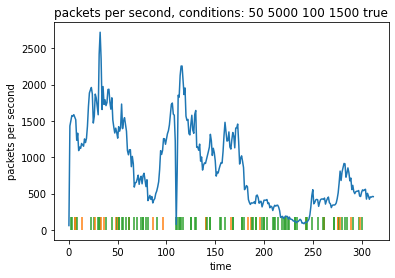

In [10]:
conditions = '50 5000 100 1500 true'
f = filenames[conditions][0]
f_drop = filenames[conditions][1]
data = pd.read_csv(f)
data_drop = pd.read_csv(f_drop, header=None)
data_drop.columns = ['drop', 'Time', 'IP1', 'Port1', 'IP2', 'Port2', '?']
clean = clean_df(data)
plt.plot(clean['1->2Pkts'])

port = data_drop['Port1']
time = data_drop['Time'] - data['Time'].min()
max_pkts = clean['1->2Pkts'].max()

for i in range(len(time)):
    # confirmation (computer 2)
    if port[i] == 5001:
        plt.vlines(time[i], 0, max_pkts / 15, colors='C1')
        pass
    # data (computer 1)
    else:
        plt.vlines(time[i], 0, max_pkts / 15, colors='C2')
        pass
        
plt.title(f'packets per second, conditions: {conditions}')
plt.ylabel('packets per second')
plt.xlabel('time')

In [11]:
def interpacket_var(stri, dirs):
    row = stri.split(';')
    direction = dirs.split(';')
    direction = np.array(row[:-1]).astype(np.int)
    times = np.array(row[:-1]).astype(np.float)
    times = times - times[0]
    times = times[direction == 1]
    diff = np.diff(times)
    return np.std(diff)

<ipython-input-9-2c46867b5383>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['group'] = df_cleaned['Time'].astype(int)//GROUP_INTERVAL # generates 10 second groupings of the data.


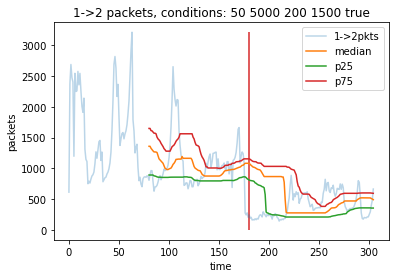

In [12]:
# Median absolute deviation
conditions = '50 5000 200 1500 true'
f = filenames[conditions][0]
f_drop = filenames[conditions][1]
data = pd.read_csv(f)
data_drop = pd.read_csv(f_drop, header=None)
feat = 0

clean = clean_df(data)

X = np.array(clean['1->2Pkts'])
#var = np.vectorize(interpacket_var)(clean['packet_times'])
#X = np.array([X,var]).T
#data_drop.columns = ['drop', 'Time', 'IP1', 'Port1', 'IP2', 'Port2', '?']

stream = pd.DataFrame(np.log(X))

mad = lambda x: np.percentile(np.fabs(x - np.percentile(x, 50)), 60)


window = 80
thresh = 1.5
median = []
p25 = []
p75 = []
lower = []
upper = []
std = []
m = []
maximum = []
stdm = []
stdm2 = []
conv = []
filt = np.flip(np.arange(window)) - window//2
#filt = np.append(np.ones(window//2), -1*np.ones(window-window//2))

for i in range(len(X) - window):
    subset = X[i:i+window]
    median = median + [np.median(subset)]
    p25 = p25 + [np.percentile(subset, 25)]
    p75 = p75 + [np.percentile(subset, 65)]
    lower = lower + [np.median(subset) - thresh*mad(subset)]
    upper = upper + [np.median(subset) + thresh*mad(subset)]
    std = std + [np.std(subset)]
    stdm = stdm + [np.sum((subset-np.median(subset)))/window]
    stdm2 = stdm2 + [np.sum((subset-np.median(subset))**2)/window]
    m = m + [mad(subset)]
    maximum = maximum + [max(subset)]
    conv = conv + [np.dot(subset, filt)/window]
    if i == 150:
        m_210 = np.fabs(subset - np.median(subset))
    
ind = np.arange(len(X)-window) + window
    
plt.plot(X,alpha=0.3, label='1->2pkts')
plt.plot(ind,median, label='median')
plt.plot(ind,p25, label='p25')
plt.plot(ind,p75, label='p75')
#plt.plot(X.index[(len(X)-len(upper)):],upper, label=f'median + {}')
#plt.plot(X.index[(len(X)-len(lower)):],lower)

#plt.plot(X.index[(len(X)-len(std)):],std)
#plt.plot(X.index[(len(X)-len(m)):],m)

plt.vlines(180, 0, max(X), colors='C3')
plt.title(f'1->2 packets, conditions: {conditions}')
plt.ylabel('packets')
plt.xlabel('time')    
plt.legend()

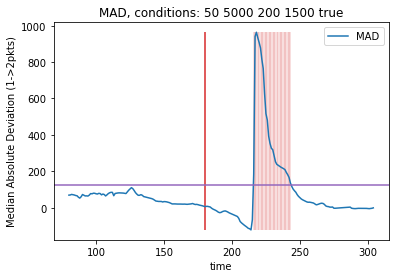

In [13]:
m = np.array(m)
index = ind
da = np.array([m,index]).T

transform = m*stdm / median
thresh = 100 / (window / 100)
mean_t = []
anom = index[(transform > thresh)]

win = 30
for i in range(len(transform) - win):
    mean_t = mean_t + [np.mean(transform[i:i+win])]

plt.plot(index, transform, label='MAD')

plt.vlines(180, min(transform), max(transform), colors='C3')
plt.vlines(anom, min(transform), max(transform), colors='C3', alpha=.2)
plt.axhline(y=thresh, color='C4')
plt.title(f'MAD, conditions: {conditions}')
plt.ylabel('Median Absolute Deviation (1->2pkts)')
plt.xlabel('time')    
plt.legend()

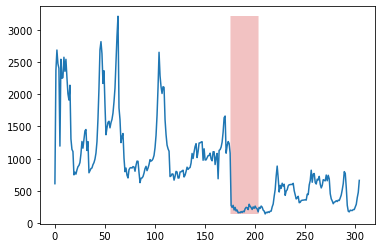

In [14]:
plt.plot(X,alpha=1, label='1->2pkts')
plt.vlines(anom-window//2, min(X), max(X), colors='C3', alpha=.2)

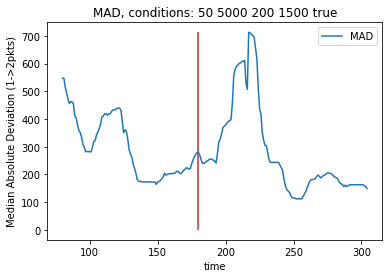

In [15]:
m = np.array(m)
index = ind
da = np.array([m,index]).T

plt.plot(index,m, label='MAD')

plt.vlines(180, 0, max(m), colors='C3')
plt.title(f'MAD, conditions: {conditions}')
plt.ylabel('Median Absolute Deviation (1->2pkts)')
plt.xlabel('time')    
plt.legend()

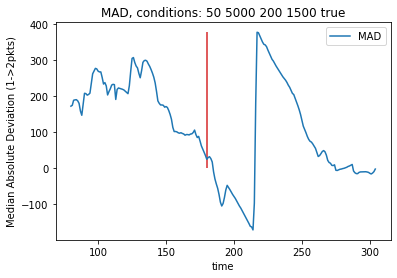

In [16]:
m = np.array(m)
index = ind
da = np.array([m,index]).T

plt.plot(index,stdm, label='MAD')


plt.vlines(180, 0, max(stdm), colors='C3')
plt.title(f'MAD, conditions: {conditions}')
plt.ylabel('Median Absolute Deviation (1->2pkts)')
plt.xlabel('time')    
plt.legend()

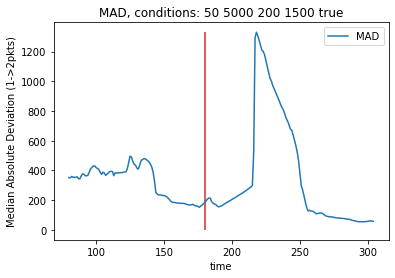

In [17]:
m = np.array(m)
index = ind
da = np.array([m,index]).T

plt.plot(index,np.array(stdm2)/median, label='MAD')


plt.vlines(180, 0, max(np.array(stdm2)/median), colors='C3')
plt.title(f'MAD, conditions: {conditions}')
plt.ylabel('Median Absolute Deviation (1->2pkts)')
plt.xlabel('time')    
plt.legend()

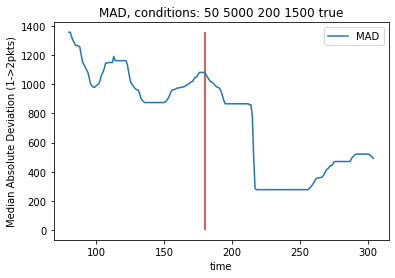

In [18]:
m = np.array(m)
index = ind
da = np.array([m,index]).T

plt.plot(index,median, label='MAD')


plt.vlines(180, 0, max(median), colors='C3')
plt.title(f'MAD, conditions: {conditions}')
plt.ylabel('Median Absolute Deviation (1->2pkts)')
plt.xlabel('time')    
plt.legend()

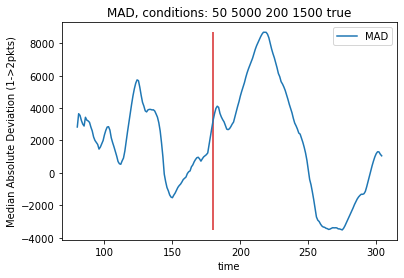

In [19]:
m = np.array(m)
index = ind
da = np.array([m,index]).T

plt.plot(index,conv, label='MAD')


plt.vlines(180, min(conv), max(conv), colors='C3')
plt.title(f'MAD, conditions: {conditions}')
plt.ylabel('Median Absolute Deviation (1->2pkts)')
plt.xlabel('time')    
plt.legend()

In [20]:
def conv_filt(X, w, f):
    conv = []
    for i in range(len(X) - w):
        subset = X[i:i+w]
        conv = conv + [np.dot(subset, f)/w]
    return conv

<ipython-input-9-2c46867b5383>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['group'] = df_cleaned['Time'].astype(int)//GROUP_INTERVAL # generates 10 second groupings of the data.
c:\users\19093\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


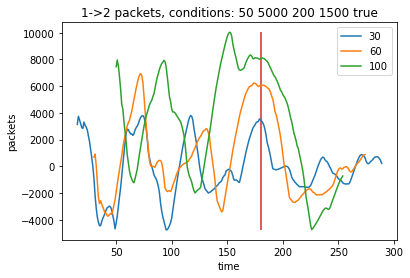

In [21]:
# convolutions on timeseries
f = filenames[conditions][0]
f_drop = filenames[conditions][1]
data = pd.read_csv(f)
data_drop = pd.read_csv(f_drop, header=None)
feat = 0

clean = clean_df(data)

X = np.array(clean['1->2Pkts'])
#var = np.vectorize(interpacket_var)(clean['packet_times'])
#X = np.array([X,var]).T
#data_drop.columns = ['drop', 'Time', 'IP1', 'Port1', 'IP2', 'Port2', '?']

stream = pd.DataFrame(np.log(X))

mad = lambda x: np.percentile(np.fabs(x - np.percentile(x, 50)), 60)


window1 = 30
window2 = 60
window3 = 100
thresh = 1.5
filt1 = np.flip(np.arange(window1)) - window1//2
filt2 = np.flip(np.arange(window2)) - window2//2
filt3 = np.flip(np.arange(window3)) - window3//2
#filt = np.append(np.ones(window//2), -1*np.ones(window-window//2))

c1 = conv_filt(X, window1, filt1)
c2 = conv_filt(X, window2, filt2)
c3 = conv_filt(X, window3, filt3)

    
ind = np.arange(len(X)-window) + window
    
plt.plot(np.arange(len(X) - window1) + window1//2, c1, label=window1)
plt.plot(np.arange(len(X) - window2) + window2//2, c2, label=window2)
plt.plot(np.arange(len(X) - window3) + window3//2, c3, label=window3)
#plt.plot(X.index[(len(X)-len(upper)):],upper, label=f'median + {}')
#plt.plot(X.index[(len(X)-len(lower)):],lower)

#plt.plot(X.index[(len(X)-len(std)):],std)
#plt.plot(X.index[(len(X)-len(m)):],m)

plt.vlines(180, min(c3), max(c3), colors='C3')
plt.title(f'1->2 packets, conditions: {conditions}')
plt.ylabel('packets')
plt.xlabel('time')    
plt.legend()

In [33]:
'''
the data (x) is a 1 dimentional numpy array of the 1->2 packets
'''
class MAD_model():
    '''
    inputs
    window_size: size of window to shift over
    thresh_height: height of the threshold to detect an anomaly on
    '''
    def __init__(self, window_size, thresh_height=100):
        self.window_size = window_size
        self.thresh = thresh_height / (window_size / 100)
        self.window = np.zeros(window_size)
        # median, median absolute deviation and deviation from median if needed later
        # for the most recent data passed into rolling_stats
        self.median = None
        self.mad = None
        self.dm = None
    
    '''
    Computes the rolling MAD, Median and average deviation from the median
    returns transform: a function of the 3 stats above
    '''
    def rolling_stats(self, x):
        mad_f = lambda x: np.percentile(np.fabs(x - np.percentile(x, 50)), 60)
        
        median = []
        dm = []
        mad = []
        
        for i in range(len(x)-self.window_size):
            subset = x[i:i+self.window_size]
            m = np.median(subset)
            median = median + [m]
            dm = dm + [np.sum((subset-m))/window]
            mad = mad + [mad_f(subset)]
        
        transform = np.array(mad)*dm / median
        self.median = median
        self.mad = mad
        self.dm = dm
        
        return transform
    
    '''
    detects an anomaly if the function of median, mad and dm are above a certain threshold
    return the indexes of where the anomaly is, already adjusted to the window size
    '''
    def detect_anomaly(self, x):
        transform = self.rolling_stats(x)
        
        index = np.arange(len(transform))
        anomaly_index = index[(transform > self.thresh)] + self.window_size // 2
        
        return anomaly_index
    
    '''
    plots the data and anomolous region detected given the data and conditions
    '''
    def plot_region(self, x, conditions, shift_time=None,  filepath=None):
        anom_region = self.detect_anomaly(x)
        
        plt.plot(x, label='1->2pkts')
        
        plt.vlines(anom_region, min(x), max(x), colors='C3', alpha=.2)
        
        if shift_time != None:
            plt.vlines(180, 0, max(x), colors='C3')
        
        plt.title(f'1->2 packets, conditions: {conditions}')
        plt.ylabel('packets')
        plt.xlabel('time')    
        plt.legend()
        
        if filepath != None:
            plt.savefig(filepath)

In [34]:
model = MAD_model(80, 100)
model.detect_anomaly(X)

array([176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188,
       189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
       202, 203])

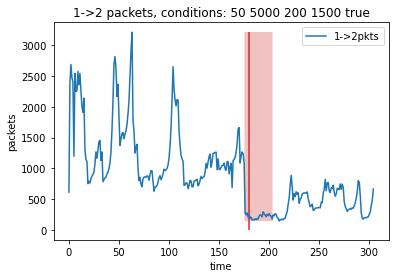

In [37]:
model.plot_region(X, '50 5000 200 1500 true', shift_time=180)